## 导入各项依赖库
- 使用jupyter notebook要正常显示图形，需要添加 %matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import calendar
import joblib
from scipy import stats
from scipy.stats import *

## 读取数据，并检查统计空值情况

In [2]:
train_data = pd.read_csv('files/train_bikes.csv')
test_data = pd.read_csv('files/test_bikes.csv')

In [3]:
train_col = train_data.columns.tolist()
test_col = test_data.columns.tolist()

In [4]:
all_data = pd.concat([train_data,test_data],ignore_index=True)
all_data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
dtype: int64

## 通过datetime字段给数据添加date、hour、weekday、month字段

In [5]:
vdata = all_data[:10886]
vdata["date"] = pd.to_datetime(vdata.datetime).dt.date
vdata["hour"] = pd.to_datetime(vdata.datetime).dt.hour
vdata["weekday"] = pd.to_datetime(vdata.datetime).dt.weekday
vdata["month"] = pd.to_datetime(vdata.datetime).dt.month

## 通过散点图观察每个特征在每天大致分布情况
可以看到weather中有一个数据点值为4，检查后确认是正常数据。其他数据分布基本正常。

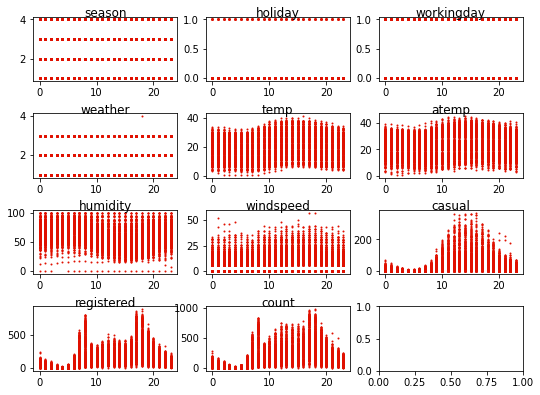

In [6]:
cols=train_data.columns
fig,subs=plt.subplots(nrows=4,ncols=3,figsize=(8,6))
plt.subplots_adjust(0.05,0.08,0.9,0.9,wspace=0.2,hspace=0.5)
subs=subs.flatten()
for k,feature in enumerate(cols[1:]):
    subs[k].scatter(pd.to_datetime(train_data['datetime']).dt.hour,train_data[feature],c='#e01000',s=1)
    subs[k].set_title(feature,y=0.9)

## 绘制蝶形图来观察数据离散情况

<AxesSubplot:xlabel='workingday', ylabel='count'>

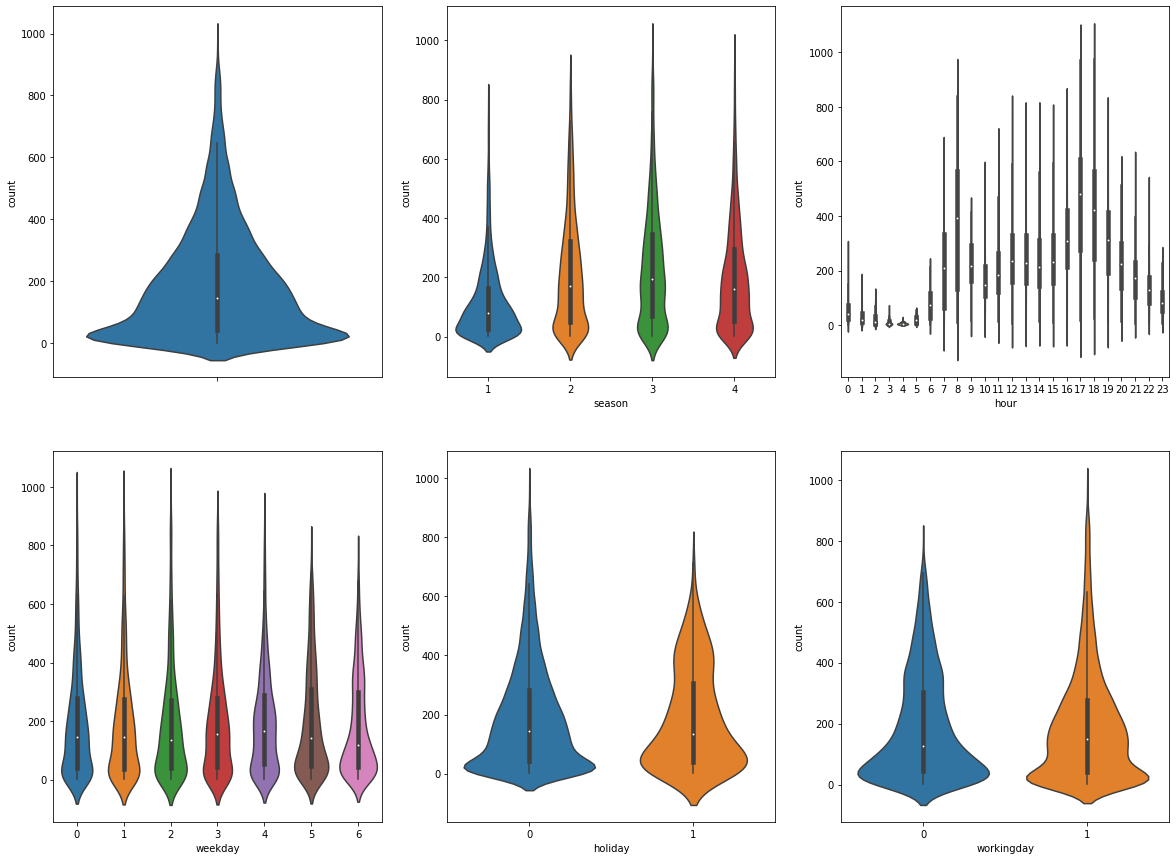

In [7]:
vdata  = vdata.drop(["datetime"],axis=1)
fig, axes = plt.subplots(2,3)
fig.set_size_inches(20, 15)
sns.violinplot(data=vdata,y="count",orient="v",ax=axes[0][0])
sns.violinplot(data=vdata,y="count",x="season",orient="v",ax=axes[0][1])
sns.violinplot(data=vdata,y="count",x="hour",orient="v",ax=axes[0][2])
sns.violinplot(data=vdata,y="count",x="weekday",orient="v",ax=axes[1][0])
sns.violinplot(data=vdata,y="count",x="holiday",orient="v",ax=axes[1][1])
sns.violinplot(data=vdata,y="count",x="workingday",orient="v",ax=axes[1][2])


## 查看数据分布情况统计图

In [8]:
def anay_data(data,col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1 
    max_ = q3+2*iqr
    min_ = q1-2*iqr
#     n = data[(data[col]>=min_)&(data[col]<=max_)][col]
    n = data[(data[col]>=min_)&(data[col]<=max_)]
    return n

#count
count_ad = anay_data(vdata,'count')['count']
print(len(count_ad),len(vdata))

#registered
registered_ad = anay_data(vdata,'registered')['registered']
print(len(registered_ad),len(vdata))

#casual
casual_ad = anay_data(vdata,'casual')['casual']
print(len(casual_ad),len(vdata))

10769 10886
10631 10886
10332 10886


<AxesSubplot:xlabel='casual', ylabel='Density'>

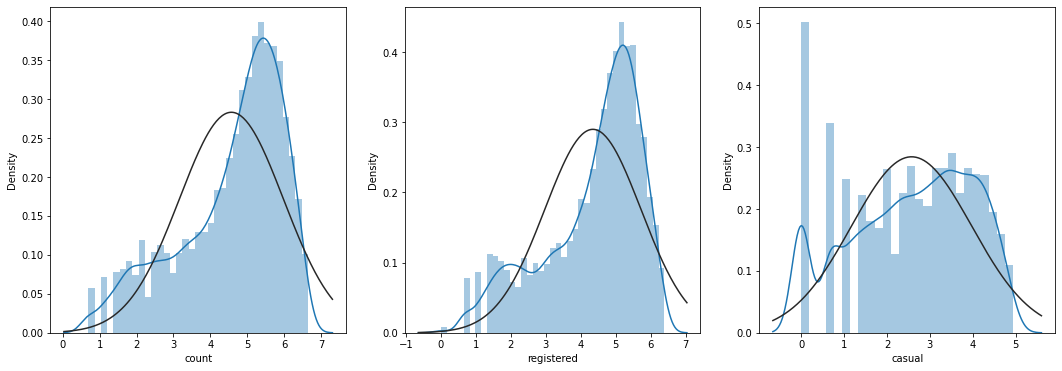

In [9]:

fig,subs = plt.subplots(1,3)
fig.set_size_inches(18, 6)
sns.distplot(np.log1p(count_ad),ax=subs[0],kde=True,fit=norm)
sns.distplot(np.log1p(registered_ad),ax=subs[1],kde=True,fit=norm)
sns.distplot(np.log1p(casual_ad),ax=subs[2],kde=True,fit=norm)

((array([-3.82570782, -3.60139334, -3.47828192, ...,  3.47828192,
          3.60139334,  3.82570782]),
  array([  0.,   0.,   0., ..., 593., 594., 594.])),
 (120.91352134473073, 142.73201015896902, 0.9482050993546497))

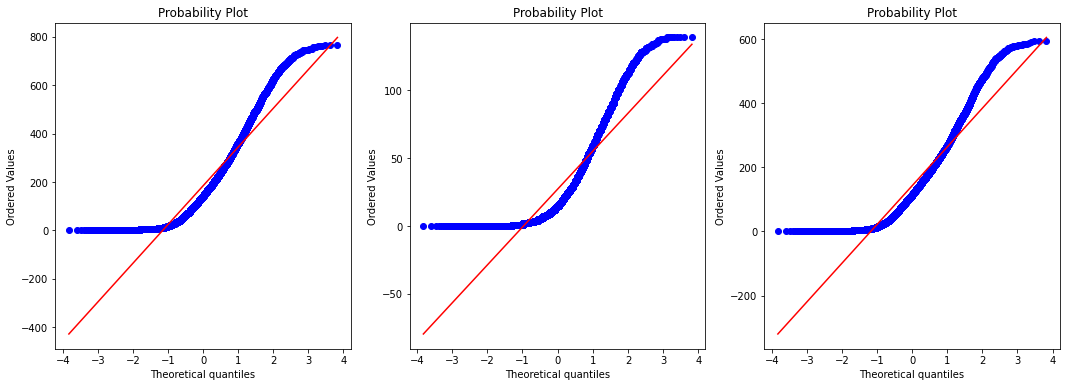

In [10]:
fig,subs = plt.subplots(1,3)
fig.set_size_inches(18, 6)
probplot(count_ad, dist='norm', fit=True, plot=subs[0])
probplot(casual_ad,dist='norm', fit=True, plot=subs[1])
probplot(registered_ad,dist='norm', fit=True, plot=subs[2])

((array([-3.82570782, -3.60139334, -3.47828192, ...,  3.47828192,
          3.60139334,  3.82570782]),
  array([0.        , 0.        , 0.        , ..., 6.38687932, 6.38856141,
         6.38856141])),
 (1.3155291717818636, 4.344479356260922, 0.955937967617917))

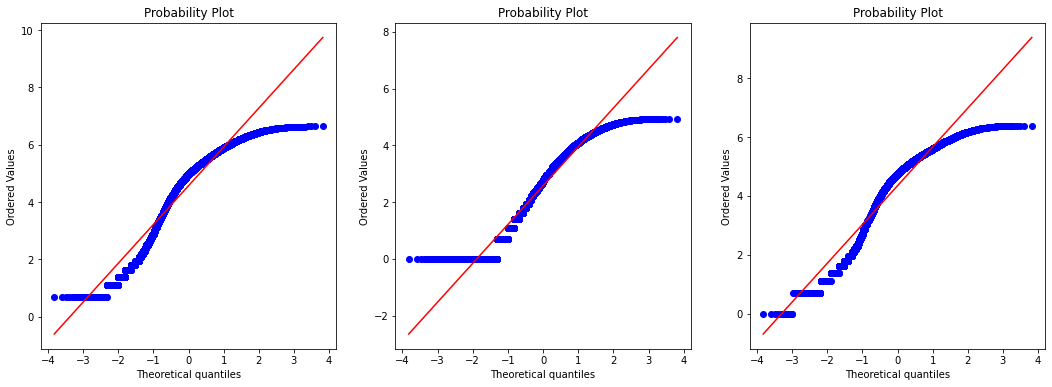

In [11]:
fig,subs = plt.subplots(1,3)
fig.set_size_inches(18, 6)
probplot(np.log1p(count_ad), dist='norm', fit=True, plot=subs[0])
probplot(np.log1p(casual_ad),dist='norm', fit=True, plot=subs[1])
probplot(np.log1p(registered_ad),dist='norm', fit=True, plot=subs[2])

In [12]:
stats.kstest(count_ad,'norm',(np.mean(count_ad),np.std(count_ad)))

KstestResult(statistic=0.13881229818001883, pvalue=1.7655090768054634e-181)

## 分析数据相关性
结论：体感温度(atemp),非注册用户(casual),注册用户(registered)有较强的正相关性，而与湿度(humdity)有明显的负相关性，和风速无明显关系

<AxesSubplot:>

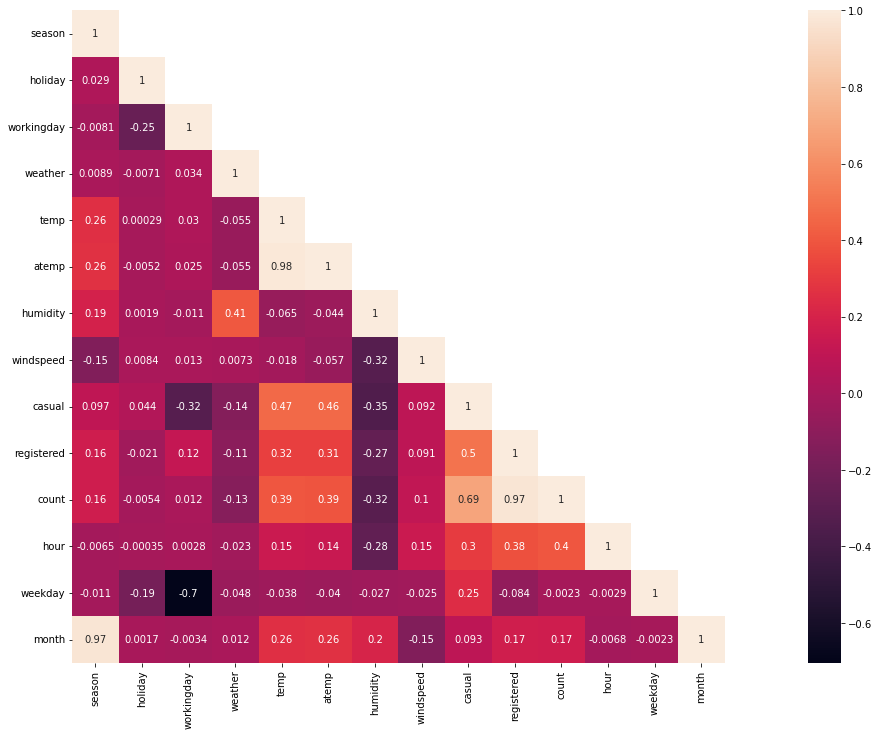

In [13]:
corr = vdata.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=corr,mask=mask,square=True,annot=True,cbar=True)

## 分析数据
- 每月用户平均数 6 7 8  三个月最多
- 四季中每周中用户数 夏秋两季用户最多，春季最少，周三最少
- 每天上下班高峰使用人数最多

## 训练模型
- model_casual :使用气象特征、时间训练预测casual值的随机森林模型
- model_registered :使用气象特征、时间训练预测registered值的随机森林模型
- model_count :使用气象特征、时间训练预测count值的随机森林模型


In [15]:
from sklearn.ensemble import RandomForestRegressor

train=pd.read_csv("files/train_bikes.csv")
features=['month','day','weekday','hour','season','holiday','workingday','weather','temp','atemp']
train['datetime']=pd.to_datetime(train['datetime'])
train['month']=train['datetime'].dt.month
train['day']=train['datetime'].dt.day
train['weekday']=train['datetime'].dt.weekday
train['hour']=train['datetime'].dt.hour
# print(train,train.describe(),train.mean(),train.std())

#预测casual的模型训练
m_casual=RandomForestRegressor(n_estimators=200,max_depth=10)
m_casual.fit(X=train[features],y=train['casual'])    
joblib.dump(m_casual,"files/model_casual")


#预测registeredl的模型训练
m_registered=RandomForestRegressor(n_estimators=200,max_depth=10)
m_registered.fit(X=train[features],y=train['registered'])    
joblib.dump(m_registered,"files/model_registered")

#预测count的模型训练
m_count=RandomForestRegressor(n_estimators=200,max_depth=10)
m_count.fit(X=train[features],y=train['count'])    
joblib.dump(m_count,"files/model_count")
print(m_casual,m_registered,m_count)


RandomForestRegressor(max_depth=10, n_estimators=200) RandomForestRegressor(max_depth=10, n_estimators=200) RandomForestRegressor(max_depth=10, n_estimators=200)


## 使用模型预测test_bikes中的casual、registered、count字段值

In [16]:
train=pd.read_csv("files/test_bikes.csv")
features=['month','day','weekday','hour','season','holiday','workingday','weather','temp','atemp']
train['datetime']=pd.to_datetime(train['datetime'])
train['month']=train['datetime'].dt.month
train['day']=train['datetime'].dt.day
train['weekday']=train['datetime'].dt.weekday
train['hour']=train['datetime'].dt.hour

#预测casual
model=joblib.load("files/model_casual")
Y=model.predict(train[features])
train['casual_pre']=Y

#预测registered
model=joblib.load("files/model_registered")
Y=model.predict(train[features])
train['registered_pre']=Y

#预测count
model=joblib.load("files/model_count")
Y=model.predict(train[features])
train['count_pre']=Y
train.to_csv("files/test_bikes_pre.csv",index=False)


## 预测结果可视化展示
- 3行12列图展示，第一行为所有月份的casual结果预测散点图，第二行为registered结果预测散点图，第三行为count结果预测散点图
- x轴是一天24h
- 12列分别表示1到12个月
- 可见预测结果基本符合训练数据集中的分布特征

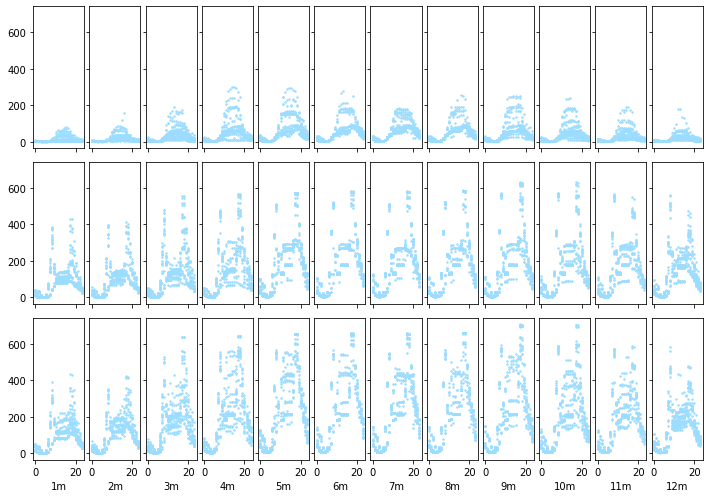

In [17]:

result=pd.read_csv("files/test_bikes_pre.csv")
features=['casual_pre','registered_pre','count_pre']
result['datetime']=pd.to_datetime(result['datetime'])
nrows,ncols=3,12
fig,subs=plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True,sharey=True)
plt.subplots_adjust(0.05,0.08,0.98,0.98,wspace=0.1,hspace=0.1)


for r in range(0,ncols):
    data=result[result['datetime'].dt.month==r+1]
    subs[0,r].scatter(data['datetime'].dt.hour,data['casual_pre'],c='#9cdcfe',s=2,alpha=1)
    subs[1,r].scatter(data['datetime'].dt.hour,data['registered_pre'],c='#9cdcfe',s=2,alpha=1)
    subs[2,r].scatter(data['datetime'].dt.hour,data['count_pre'],c='#9cdcfe',s=2,alpha=1)
    subs[2,r].set_xlabel("{}m".format(r+1))
plt.show()